# Baseline Komorebi

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [18]:
root_folder = "/Users/alvaroleal/Desktop/DS/komorebi"

df = pd.read_parquet(root_folder + '/muestreos_parcelas.parquet')

### Limpiamos los datos con los resultados del EDAs

In [19]:
def clean_df(df):
    """
    Función para realizar todo el lipiado de datos, en este momento elimina las filas del DataFrame donde el año es 2005, 2021 o 2022.

    Args:
    df (pd.DataFrame): DataFrame original.

    Returns:
    pd.DataFrame: DataFrame limpiado.
    """
    # Añadimos los resultados del EDAs
    df = df.drop('generated_muestreos', axis=1)  
    cols = ['fecha'] + [col for col in df.columns if col != 'fecha']
    df = df[cols]
    df['fecha'] = df['fecha'].astype('datetime64[ns]')
    df = df[~df['fecha'].dt.year.isin([2003, 2005, 2021, 2022])]
    
    return df

In [20]:
df = clean_df(df)

## Baseline calculation: 
- Simplificamos nuestro dataset reduciéndolo a tres columnas.
- Calculamos los estados fenológicos que ha avanzado cada instancia de cada parcela por año, ajustamos los avances negativos debido a errores en el muestreo y añadimos NaN a las primera y última instancia de cada parcela en cada año para no incluir informaciones de distintas cosechas.
- Calculamos la media para cada estado cada año ponderando más los años más recientes y creamos nuestro target.

In [21]:
columnas_estados = [f'estado_fenologico_{i}' for i in range(14, 0, -1)]

df['estado_fenologico_unificado'] = df.apply(lambda row: next((col.split('_')[-1] for col in columnas_estados if row[col] == 2), pd.NA), axis=1)
df['estado_fenologico_unificado'] = pd.to_numeric(df['estado_fenologico_unificado'])

df = df[['codparcela','fecha','estado_fenologico_unificado']]

In [22]:
df = df.copy()
df.reset_index(drop=True, inplace=True)
df.sort_values(by=['codparcela', 'fecha'], inplace=True)
df['year'] = df['fecha'].dt.year

# Ajustamos estados fenológicos regresivos para evitar 'y' negativas
for i in range(len(df) - 1): 
    if df.at[i, 'codparcela'] == df.at[i + 1, 'codparcela'] and df.at[i, 'year'] == df.at[i + 1, 'year']:
        if df.at[i + 1, 'estado_fenologico_unificado'] < df.at[i, 'estado_fenologico_unificado']:
            df.at[i + 1, 'estado_fenologico_unificado'] = df.at[i, 'estado_fenologico_unificado']

# Calculamos la diferencia entre el estado fenológico siguiente y el actual
df['y'] = df.groupby(['codparcela', 'year'], observed=True)['estado_fenologico_unificado'].shift(-1) - df['estado_fenologico_unificado']

# Establecemos NaN en la primera y última entrada de cada grupo para evitar data leakage entre distintas cosechas
first_last_mask = (df['fecha'] == df.groupby(['codparcela', 'year'], observed=True)['fecha'].transform('first')) | \
                  (df['fecha'] == df.groupby(['codparcela', 'year'], observed=True)['fecha'].transform('last'))
df.loc[first_last_mask, 'y'] = np.nan

df.head(12)

,codparcela,fecha,estado_fenologico_unificado,year,y
3960,000-00000-00,2015-08-25,10.0,2015,NaN
3961,000-00000-00,2015-09-30,11.0,2015,NaN
16815,000-00000-00-0,2015-08-24,10.0,2015,NaN
7323,000-00000-00-0,2015-08-26,10.0,2015,1.0
16816,000-00000-00-0,2015-09-28,11.0,2015,0.0
7324,000-00000-00-0,2015-09-29,11.0,2015,NaN
131747,000-00900-00-U0,2006-04-24,2.0,2006,NaN
131748,000-00900-00-U0,2006-05-03,2.0,2006,1.0
131749,000-00900-00-U0,2006-05-08,3.0,2006,1.0
131750,000-00900-00-U0,2006-05-16,4.0,2006,3.0


## Baseline predict:
- Train/Test Split: Dividimos nuestro dataset por cosechas utilizando 2018 como el punto de inversión.
- Calculamos la media ponderada agrupando por año y estado fenológico, convertimos ese dataframe a un diccionario el cual luego usamos para mapear el conjunto de test y realizar las predicciones.
- Redondeamos nuestras predicciones para poder evaluar el modelo.
- Utilizamos accuracy como métrica de evaluación del modelo obteniendo un 76% de aciertos.

In [23]:
# Dividimos nuestras muestras por años
train = df[df['year'] <= 2018].copy()
test = df[df['year'] > 2018].copy()

In [24]:
max_year = train['year'].max()
train['weight'] = train['year'].apply(lambda x: 0.1 ** (max_year - x))

# Agrupamos por estado fenológico y año, y calcular la media ponderada
grouped = train.groupby(['estado_fenologico_unificado', 'year'])
weighted_means = grouped.apply(lambda x: (x['y'] * x['weight']).sum() / x['weight'].sum()).reset_index()
weighted_means.rename(columns={0: 'weighted_mean'}, inplace=True)

# Convertimos este DataFrame en un diccionario donde la clave es el estado y el valor es la media ponderada más reciente
mapeo_referencia = weighted_means.sort_values('year', ascending=False).drop_duplicates('estado_fenologico_unificado').set_index('estado_fenologico_unificado')['weighted_mean'].to_dict()

# Aplicamos el mapeo de referencia al conjunto de test para obtener las predicciones
test['y_pred'] = test['estado_fenologico_unificado'].map(mapeo_referencia)

# Redondeamos las predicciones ya que la métrica de precisión requiere valores discretos
test['y_pred_rounded'] = test['y_pred'].round()

In [25]:
# Eliminamos filas con NaN en 'y' antes de calcular la precisión.
mask = test['y'].notna()
test_filtered = test[mask]

# Ahora, calculamos la precisión solo en las filas sin NaN.
accuracy = accuracy_score(test_filtered['y'], test_filtered['y_pred_rounded'])
print(f"Baseline Model Accuracy: {accuracy}")

Baseline Model Accuracy: 0.7579984393289114


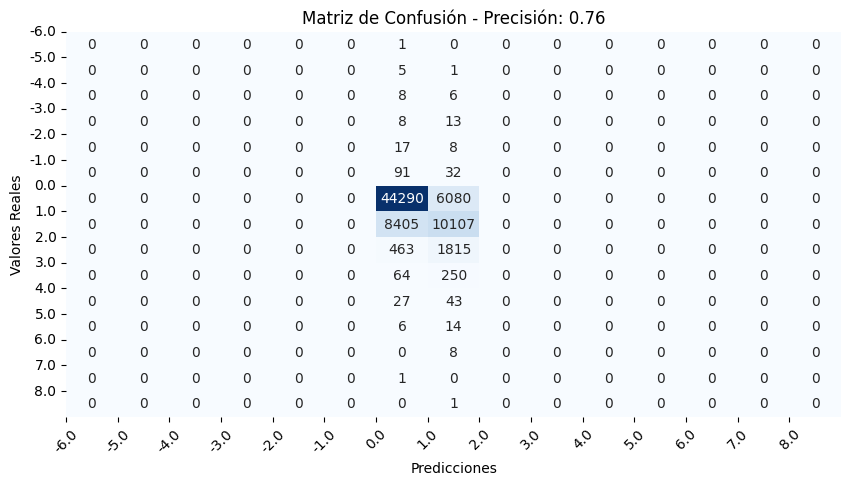

In [26]:
cm = confusion_matrix(test_filtered['y'], test_filtered['y_pred_rounded'])

accuracy = accuracy_score(test_filtered['y'], test_filtered['y_pred_rounded'])

plt.figure(figsize=(10, 5))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=True, yticklabels=True) 

plt.title(f'Matriz de Confusión - Precisión: {accuracy:.2f}')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')

unique_classes = sorted(test_filtered['y'].unique())
plt.xticks(ticks=range(len(unique_classes)), labels=unique_classes, rotation=45) 
plt.yticks(ticks=range(len(unique_classes)), labels=unique_classes, rotation=0)

plt.show()

## Conclusiones:

Acercamiento muy sencillo a lo que podría suponer un punto de partida para tratar de hacer modelos más complejos, cual feedback es bienvenido :)

*Cálculo del Baseline:*

- Calculamos un modelo muy sencillo definiendo el target como elnúmero de estados fenológicos que había pasado una muestra con respecto a su instancia anterior. Se corrigieron los avances fenológicos negativos resultantes de errores en el muestreo y se excluyeron las instancias iniciales y finales de cada año para evitar inconsistencias entre diferentes cosechas.

*Predicción del Baseline:*

- Implementamos una división del dataset por cosechas, utilizando el año 2018 como punto de corte. Esto permitió que las fases de prueba y entrenamiento reflejen las condiciones más actuales sin mezclar datos de cosechas anteriores.
Se empleó una media ponderada para cada combinación de año y estado fenológico, convirtiendo luego este dataframe en un diccionario que fue utilizado para mapear y realizar predicciones en el conjunto de test. Nota: Podemos probar con otros criterios estadísticos con la mediana para ver cómo cambia la métrica de evaluación.

*Evaluación del Baseline:*

- Las predicciones fueron ajustadas mediante redondeo para facilitar la evaluación con la métrica de precisión. El modelo alcanzó una precisión inicial del 76%.
